## Importing the required libraries and loading data

In [ ]:
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 19.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is 

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from sklearn.model_selection import train_test_split

import os
import pathlib
import librosa
import json

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## data-preprocessing

In [ ]:

DATASET_PATH = 'data/mini_speech_commands'
JSON_PATH = "data.json"
SAMPLES_TO_CONSIDER = 22050  # 1 second of audio

def extract_features(file_path, samples_to_consider=SAMPLES_TO_CONSIDER):
    signal, sample_rate = librosa.load(file_path)

    if len(signal) >= samples_to_consider:
        signal = signal[:samples_to_consider]

        num_mfcc = 13
        n_fft = 2048
        hop_length = 512
        MFCCs = librosa.feature.mfcc(y=signal, n_mfcc=num_mfcc, hop_length=hop_length, n_fft=n_fft)

        return MFCCs.T.tolist()
    else:
        return None

def preprocess_data(dataset_path, json_path):
    data = {"mapping": [], "labels": [], "MFCCs": [], "files": []}

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            label = dirpath.split("/")[-1]
            data["mapping"].append(label)

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                MFCCs = extract_features(file_path)

                if MFCCs:
                    data["MFCCs"].append(MFCCs)
                    data["labels"].append(i - 1)
                    data["files"].append(file_path)

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

# Main code
preprocess_data(DATASET_PATH, JSON_PATH)

## Training and test of data

In [ ]:
DATA_PATH = "data.json"
JSON_PATH = "data.json"

# Define prepare_dataset function
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    try:
        # Load dataset
        with open(data_path, "r") as fp:
            data = json.load(fp)

        # Extract features and labels
        X = np.array(data["MFCCs"])
        y = np.array(data["labels"])

        # Print information
        print("Dataset loaded.")

        # Create train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Further split train set into train-validation sets
        X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=42)

        # Reshape arrays to include channel dimension
        X_train = X_train[..., np.newaxis]
        X_test = X_test[..., np.newaxis]
        X_validation = X_validation[..., np.newaxis]

        return X_train, y_train, X_validation, y_validation, X_test, y_test

    except Exception as e:
        print("Error occurred while preparing dataset:", str(e))
        return None, None, None, None, None, None

# Call prepare_dataset function
X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

# Check if the dataset is loaded successfully
if X_train is not None:
    print("Train set shape:", X_train.shape)
    print("Validation set shape:", X_validation.shape)
    print("Test set shape:", X_test.shape)
else:
    print("Dataset loading failed. Please check the data path.")

Dataset loaded.
Train set shape: (4593, 44, 13, 1)
Validation set shape: (1149, 44, 13, 1)
Test set shape: (1436, 44, 13, 1)


## Model Training & testing

### DNN Model

In [ ]:
def build_dnn(input_shape, num_classes, loss="sparse_categorical_crossentropy", learning_rate=0.001):
    try:
        # Initialize a sequential model
        model = tf.keras.models.Sequential()

        # Add convolutional layers
        model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

        # Flatten the output
        model.add(tf.keras.layers.Flatten())

        # Add dense layers with dropout
        model.add(tf.keras.layers.Dense(256, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.Dense(64, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.3))

        # Add output layer with softmax activation
        model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

        # Define optimizer
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

        # Compile the model
        model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

        # Print model summary
        model.summary()

        return model

    except Exception as e:
        print("An error occurred while building the DNN model:", str(e))
        return None

# Define input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2], 1)
num_classes = len(np.unique(y_train))

# Build the DNN model
model = build_dnn(input_shape, num_classes, learning_rate=0.001)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 40
BATCH_SIZE = 16
PATIENCE = 5

def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    try:
        # Define early stopping callback
        earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=patience, restore_best_weights=True)

        # Train the model
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_validation, y_validation),
                            callbacks=[earlystop_callback])

        return history

    except Exception as e:
        print("An error occurred during training:", str(e))
        return None

# Train the network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)


Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1491 - loss: 4.3982 - val_accuracy: 0.3229 - val_loss: 1.7760
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.3277 - loss: 1.7687 - val_accuracy: 0.4500 - val_loss: 1.4585
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4483 - loss: 1.4442 - val_accuracy: 0.5883 - val_loss: 1.1286
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5203 - loss: 1.2633 - val_accuracy: 0.6118 - val_loss: 0.9673
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5804 - loss: 1.0706 - val_accuracy: 0.6789 - val_loss: 0.8806
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6143 - loss: 1.0549 - val_accuracy: 0.6797 - val_loss: 0.8886
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6603 - loss: 0.9110 - val_accuracy: 0.6841 - val_loss: 0.8203
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6624 - loss: 0.9203 - val_acc

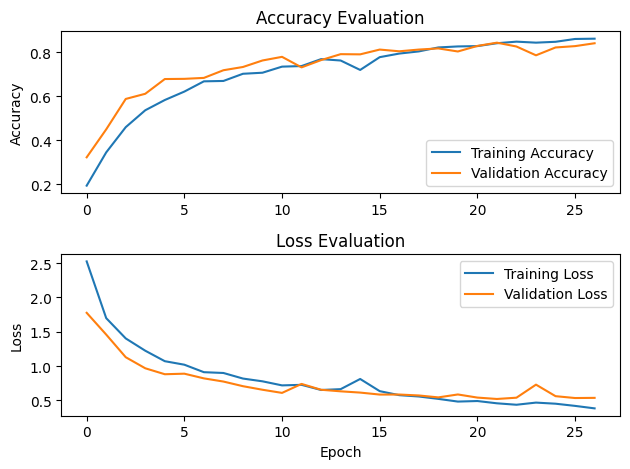

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    try:
        # Create figure and axes
        fig, axs = plt.subplots(2)

        # Plot accuracy
        axs[0].plot(history.history["accuracy"], label="Training Accuracy")
        axs[0].plot(history.history['val_accuracy'], label="Validation Accuracy")
        axs[0].set_ylabel("Accuracy")
        axs[0].set_title("Accuracy Evaluation")
        axs[0].legend(loc="lower right")

        # Plot loss
        axs[1].plot(history.history["loss"], label="Training Loss")
        axs[1].plot(history.history['val_loss'], label="Validation Loss")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].set_title("Loss Evaluation")
        axs[1].legend(loc="upper right")

        # Adjust layout
        plt.tight_layout()

        # Show plot
        plt.show()

    except Exception as e:
        print("An error occurred while plotting history:", str(e))

# Plot accuracy/loss for training/validation set
plot_history(history)


In [ ]:
# Evaluate network on test set
def evaluate_model(model, X_test, y_test):
    try:
        # Evaluate the model
        test_loss, test_acc = model.evaluate(X_test, y_test)

        # Print the evaluation results
        print("\nTest Loss:", test_loss)
        print("Test Accuracy:", test_acc * 100, "%")

    except Exception as e:
        print("An error occurred during evaluation:", str(e))

# Call the evaluate_model function
evaluate_model(model, X_test, y_test)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8145 - loss: 0.6271

Test Loss: 0.6217619776725769
Test Accuracy: 80.8495819568634 %


## Experiment with different Learning rate

In [ ]:
from tabulate import tabulate

# Array of different values of learning rate
lr_array = [0.00001, 0.0001, 0.001, 0.01, 0.1]
result = []

for lr in lr_array:
    print(f"\nTraining model with learning rate: {lr}")
    temp = []
    model = build_dnn(input_shape, learning_rate=lr, num_classes=8)
    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test loss with learning rate {lr}: {test_loss}, Test accuracy: {test_acc}")
    temp.extend([lr, test_loss, test_acc])
    result.append(temp)

# Create header
head = ["Learning Rate", "Test Loss", "Test Accuracy"]

# Display table
print(tabulate(result, headers=head, tablefmt="grid"))



Training model with learning rate: 1e-05


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1359 - loss: 30.9349 - val_accuracy: 0.1462 - val_loss: 5.7785
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.1258 - loss: 16.5076 - val_accuracy: 0.1619 - val_loss: 3.3714
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.1389 - loss: 10.5191 - val_accuracy: 0.1471 - val_loss: 2.5563
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.1434 - loss: 7.1064 - val_accuracy: 0.1671 - val_loss: 2.2562
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.1413 - loss: 5.5120 - val_accuracy: 0.1836 - val_loss: 2.1514
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.1383 - loss: 4.4836 - val_accuracy: 0.2010 - val_loss: 2.0897
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1515 - loss: 3.7110 - val_accuracy: 0.2185 - val_loss: 2.0516
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.1518 - loss: 3.1866 - val_

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.1271 - loss: 17.2781 - val_accuracy: 0.1784 - val_loss: 2.0916
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.1471 - loss: 2.5840 - val_accuracy: 0.2263 - val_loss: 1.9965
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.1608 - loss: 2.0856 - val_accuracy: 0.2672 - val_loss: 1.9637
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.1816 - loss: 2.0304 - val_accuracy: 0.3046 - val_loss: 1.8774
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2138 - loss: 1.9681 - val_accuracy: 0.3316 - val_loss: 1.8502
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2402 - loss: 1.9401 - val_accuracy: 0.3603 - val_loss: 1.7852
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2596 - loss: 1.8957 - val_accuracy: 0.3534 - val_loss: 1.7314
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2798 - loss: 1.8403 - val_ac

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1621 - loss: 4.1028 - val_accuracy: 0.3603 - val_loss: 1.6911
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3334 - loss: 1.7119 - val_accuracy: 0.4360 - val_loss: 1.5071
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4595 - loss: 1.4226 - val_accuracy: 0.5805 - val_loss: 1.0976
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5514 - loss: 1.1738 - val_accuracy: 0.6458 - val_loss: 0.9579
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6024 - loss: 1.0821 - val_accuracy: 0.6414 - val_loss: 0.9438
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6592 - loss: 0.9199 - val_accuracy: 0.7015 - val_loss: 0.7892
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6781 - loss: 0.8638 - val_accuracy: 0.7537 - val_loss: 0.6741
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7291 - loss: 0.7536 - val_accu

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1404 - loss: 4.3059 - val_accuracy: 0.1366 - val_loss: 2.0801
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.1200 - loss: 2.0825 - val_accuracy: 0.1140 - val_loss: 2.0846
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1303 - loss: 2.0809 - val_accuracy: 0.1210 - val_loss: 2.0831
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1204 - loss: 2.0879 - val_accuracy: 0.1210 - val_loss: 2.0811
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1258 - loss: 2.0821 - val_accuracy: 0.1227 - val_loss: 2.0821
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1328 - loss: 2.0806 - val_accuracy: 0.1227 - val_loss: 2.0809
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1185 - loss: 2.0808
Test loss with learning rate 0.01: 2.080792188644409, Test accuracy: 0.12047354131937027

Training model with learning rate: 0.1


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1226 - loss: 1796.5704 - val_accuracy: 0.1323 - val_loss: 2.0867
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.1393 - loss: 2.0894 - val_accuracy: 0.1227 - val_loss: 2.0915
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.1176 - loss: 2.1030 - val_accuracy: 0.1210 - val_loss: 2.0961
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.1247 - loss: 2.1004 - val_accuracy: 0.1227 - val_loss: 2.0836
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.1325 - loss: 2.0987 - val_accuracy: 0.1227 - val_loss: 2.0969
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.1256 - loss: 2.0926 - val_accuracy: 0.1227 - val_loss: 2.1263
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1407 - loss: 2.0871
Test loss with learning rate 0.1: 2.089223623275757, Test accuracy: 0.1385793834924698
+-----------------+-------------+-----------------+
|   Learn

## Experiment with different Batch Size


Training model with batch size: 16


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1322 - loss: 4.9458 - val_accuracy: 0.2237 - val_loss: 1.9906
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.2063 - loss: 1.9871 - val_accuracy: 0.4003 - val_loss: 1.5356
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3511 - loss: 1.6403 - val_accuracy: 0.4439 - val_loss: 1.4292
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4176 - loss: 1.4397 - val_accuracy: 0.5448 - val_loss: 1.2885
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5273 - loss: 1.2569 - val_accuracy: 0.6258 - val_loss: 0.9824
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5871 - loss: 1.1148 - val_accuracy: 0.6554 - val_loss: 0.9488
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6249 - loss: 0.9832 - val_accuracy: 0.7093 - val_loss: 0.7926
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6398 - loss: 0.9731 - val_accu

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.1451 - loss: 5.3965 - val_accuracy: 0.2411 - val_loss: 1.9596
Epoch 2/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.2330 - loss: 1.9616 - val_accuracy: 0.3455 - val_loss: 1.6996
Epoch 3/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3330 - loss: 1.7552 - val_accuracy: 0.5048 - val_loss: 1.4389
Epoch 4/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4309 - loss: 1.5433 - val_accuracy: 0.6075 - val_loss: 1.1527
Epoch 5/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5405 - loss: 1.2664 - val_accuracy: 0.6745 - val_loss: 0.9350
Epoch 6/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6220 - loss: 1.0545 - val_accuracy: 0.6902 - val_loss: 0.8676
Epoch 7/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6541 - loss: 0.9510 - val_accuracy: 0.7067 - val_loss: 0.8184
Epoch 8/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6823 - loss: 0.8671 - val_accu

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.1291 - loss: 7.5441 - val_accuracy: 0.2141 - val_loss: 2.0087
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.2122 - loss: 1.9798 - val_accuracy: 0.3655 - val_loss: 1.7171
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3121 - loss: 1.7865 - val_accuracy: 0.4204 - val_loss: 1.5765
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.3541 - loss: 1.6371 - val_accuracy: 0.5117 - val_loss: 1.4529
Epoch 5/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4409 - loss: 1.4977 - val_accuracy: 0.5753 - val_loss: 1.1643
Epoch 6/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5186 - loss: 1.2889 - val_accuracy: 0.6110 - val_loss: 1.0730
Epoch 7/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5747 - loss: 1.1316 - val_accuracy: 0.6614 - val_loss: 0.8742
Epoch 8/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6370 - loss: 0.9722 - val_accuracy: 0.7198 - v

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.1400 - loss: 8.7322 - val_accuracy: 0.2185 - val_loss: 2.0451
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.1556 - loss: 2.0775 - val_accuracy: 0.2541 - val_loss: 1.9354
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.2282 - loss: 1.9522 - val_accuracy: 0.3368 - val_loss: 1.8324
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.2811 - loss: 1.8642 - val_accuracy: 0.3586 - val_loss: 1.7320
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.3088 - loss: 1.8074 - val_accuracy: 0.3829 - val_loss: 1.5836
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3584 - loss: 1.6678 - val_accuracy: 0.4778 - val_loss: 1.4634
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.4265 - loss: 1.5108 - val_accuracy: 0.5318 - val_loss: 1.2843
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4613 - loss: 1.4073 - val_accuracy: 0.5674 - 

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.1268 - loss: 13.2304 - val_accuracy: 0.1741 - val_loss: 2.0552
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.1495 - loss: 2.1116 - val_accuracy: 0.2185 - val_loss: 2.0447
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.1689 - loss: 2.0480 - val_accuracy: 0.3299 - val_loss: 1.9567
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.2191 - loss: 1.9685 - val_accuracy: 0.3734 - val_loss: 1.7844
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.2885 - loss: 1.8419 - val_accuracy: 0.4456 - val_loss: 1.6229
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.3584 - loss: 1.6881 - val_accuracy: 0.4996 - val_loss: 1.4923
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.4188 - loss: 1.5516 - val_accuracy: 0.5535 - val_loss: 1.2816
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.4585 - loss: 1.4501 - val_accuracy: 0

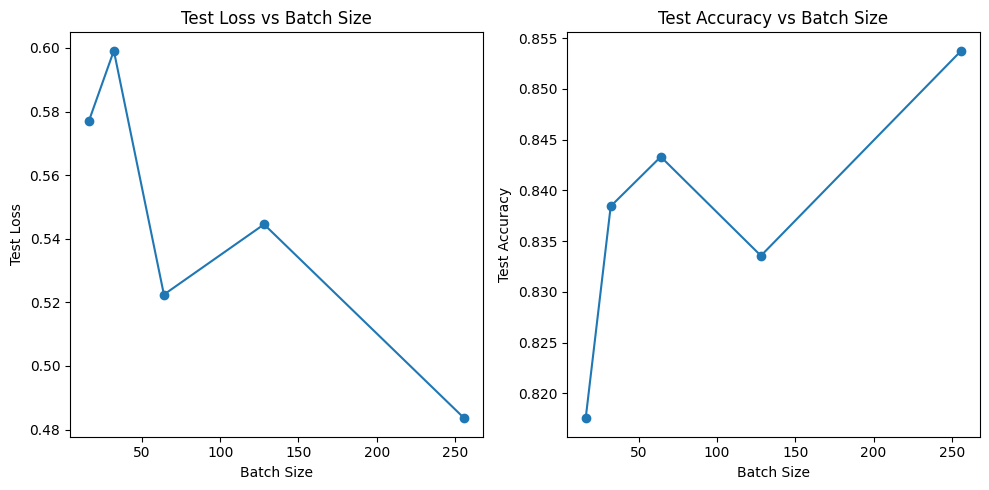

In [ ]:
from tabulate import tabulate
import matplotlib.pyplot as plt

LEARNING_RATE = 0.001
# Array of different values of batch size
batch_array = [16, 32, 64, 128, 256]
result1 = []

for batch_size in batch_array:
    print(f"\nTraining model with batch size: {batch_size}")
    temp = []
    model = build_dnn(input_shape, learning_rate=LEARNING_RATE, num_classes=8)
    history = train(model, EPOCHS, batch_size, PATIENCE, X_train, y_train, X_validation, y_validation)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test loss with batch size {batch_size}: {test_loss}, Test accuracy: {test_acc}")
    temp.extend([batch_size, test_loss, test_acc])
    result1.append(temp)

# Create header
head1 = ["Batch Size", "Test Loss", "Test Accuracy"]

# Display table
print(tabulate(result1, headers=head1, tablefmt="grid"))

# Plotting test loss and accuracy for each batch size
batch_sizes = [row[0] for row in result1]
test_losses = [row[1] for row in result1]
test_accuracies = [row[2] for row in result1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(batch_sizes, test_losses, marker='o')
plt.title('Test Loss vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Test Loss')

plt.subplot(1, 2, 2)
plt.plot(batch_sizes, test_accuracies, marker='o')
plt.title('Test Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy')

plt.tight_layout()
plt.show()


## Experiment with different Epoch value


Training model with 20 epochs


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1544 - loss: 4.0262 - val_accuracy: 0.3534 - val_loss: 1.7698
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2973 - loss: 1.8029 - val_accuracy: 0.4256 - val_loss: 1.4954
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4183 - loss: 1.5539 - val_accuracy: 0.6040 - val_loss: 1.1683
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5222 - loss: 1.2804 - val_accuracy: 0.6789 - val_loss: 0.9231
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6107 - loss: 1.0621 - val_accuracy: 0.6876 - val_loss: 0.8709
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6440 - loss: 0.9395 - val_accuracy: 0.7058 - val_loss: 0.8193
Epoch 7/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6896 - loss: 0.8556 - val_accuracy: 0.7041 - val_loss: 0.7951
Epoch 8/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7113 - loss: 0.8088 - val_acc

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1337 - loss: 6.0839 - val_accuracy: 0.2820 - val_loss: 1.7741
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3012 - loss: 1.8270 - val_accuracy: 0.4935 - val_loss: 1.3911
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4350 - loss: 1.4907 - val_accuracy: 0.5866 - val_loss: 1.1745
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5243 - loss: 1.2567 - val_accuracy: 0.6136 - val_loss: 1.0231
Epoch 5/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5813 - loss: 1.0904 - val_accuracy: 0.6606 - val_loss: 0.9033
Epoch 6/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6068 - loss: 1.0612 - val_accuracy: 0.6423 - val_loss: 0.9232
Epoch 7/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6560 - loss: 0.9245 - val_accuracy: 0.7224 - val_loss: 0.7684
Epoch 8/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6995 - loss: 0.8193 - val_accu

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.1447 - loss: 5.9428 - val_accuracy: 0.2933 - val_loss: 1.8773
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2692 - loss: 1.9172 - val_accuracy: 0.4326 - val_loss: 1.5167
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4258 - loss: 1.5588 - val_accuracy: 0.5840 - val_loss: 1.1180
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4981 - loss: 1.3411 - val_accuracy: 0.5927 - val_loss: 0.9920
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5673 - loss: 1.1361 - val_accuracy: 0.6197 - val_loss: 1.0137
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6064 - loss: 1.0272 - val_accuracy: 0.7111 - val_loss: 0.8440
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6721 - loss: 0.8904 - val_accuracy: 0.7180 - val_loss: 0.7751
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7035 - loss: 0.8079 - val_accu

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1427 - loss: 4.9967 - val_accuracy: 0.3238 - val_loss: 1.8341
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.2902 - loss: 1.8280 - val_accuracy: 0.4186 - val_loss: 1.5271
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3891 - loss: 1.6030 - val_accuracy: 0.5448 - val_loss: 1.2801
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4916 - loss: 1.3564 - val_accuracy: 0.6162 - val_loss: 1.0341
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5720 - loss: 1.1570 - val_accuracy: 0.6797 - val_loss: 0.9400
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6368 - loss: 1.0087 - val_accuracy: 0.6832 - val_loss: 0.8382
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6570 - loss: 0.9224 - val_accuracy: 0.7232 - val_loss: 0.7472
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6896 - loss: 0.8192 - val_acc

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_21 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.1562 - loss: 4.5418 - val_accuracy: 0.3316 - val_loss: 1.7721
Epoch 2/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2945 - loss: 1.8147 - val_accuracy: 0.4648 - val_loss: 1.4767
Epoch 3/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4398 - loss: 1.4938 - val_accuracy: 0.5257 - val_loss: 1.2950
Epoch 4/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5271 - loss: 1.2971 - val_accuracy: 0.6005 - val_loss: 1.0336
Epoch 5/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5576 - loss: 1.1998 - val_accuracy: 0.6997 - val_loss: 0.8489
Epoch 6/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5863 - loss: 1.1395 - val_accuracy: 0.6867 - val_loss: 0.8418
Epoch 7/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6407 - loss: 0.9542 - val_accuracy: 0.7398 - val_loss: 0.7399
Epoch 8/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7097 - loss: 0.8001 - val_ac

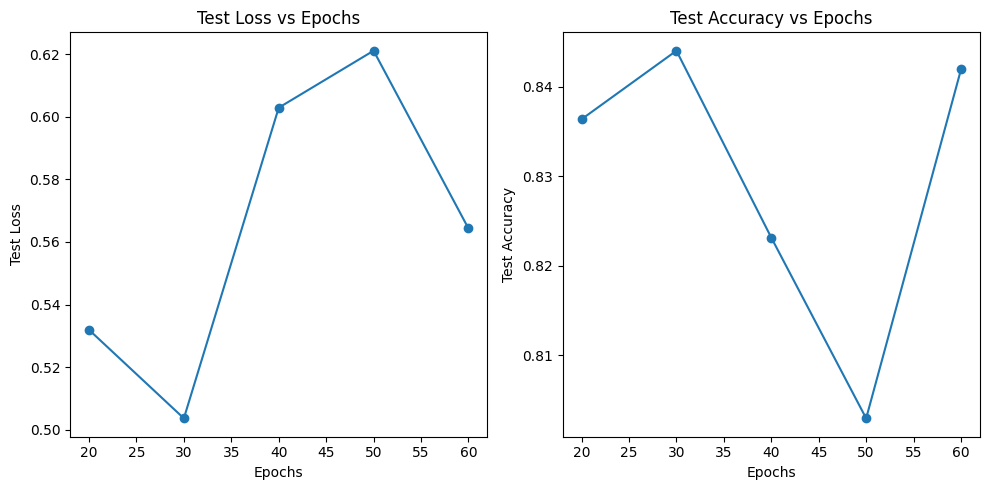

In [ ]:
from tabulate import tabulate
import matplotlib.pyplot as plt

# Array of different values of epochs
epoch_array = [20, 30, 40, 50, 60]
result2 = []

for epochs in epoch_array:
    print(f"\nTraining model with {epochs} epochs")
    temp = []
    model = build_dnn(input_shape, learning_rate=LEARNING_RATE, num_classes=8)
    history = train(model, epochs, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test loss with {epochs} epochs: {test_loss}, Test accuracy: {test_acc}")
    temp.extend([epochs, test_loss, test_acc])
    result2.append(temp)

# Create header
head2 = ["Epoch", "Test Loss", "Test Accuracy"]

# Display table
print(tabulate(result2, headers=head2, tablefmt="grid"))

# Plotting test loss and accuracy for each number of epochs
epochs_values = [row[0] for row in result2]
test_losses = [row[1] for row in result2]
test_accuracies = [row[2] for row in result2]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_values, test_losses, marker='o')
plt.title('Test Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_values, test_accuracies, marker='o')
plt.title('Test Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')

plt.tight_layout()
plt.show()


## Experiment with different PATIENCE VALUE


Training model with patience=3


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1619 - loss: 5.0173 - val_accuracy: 0.3246 - val_loss: 1.7871
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2986 - loss: 1.7961 - val_accuracy: 0.4534 - val_loss: 1.4432
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4217 - loss: 1.4997 - val_accuracy: 0.5361 - val_loss: 1.2090
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5163 - loss: 1.2760 - val_accuracy: 0.6554 - val_loss: 1.0156
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5868 - loss: 1.0914 - val_accuracy: 0.6693 - val_loss: 0.8670
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6185 - loss: 0.9826 - val_accuracy: 0.7023 - val_loss: 0.7605
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6945 - loss: 0.8498 - val_accuracy: 0.7171 - val_loss: 0.8260
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6951 - loss: 0.8405 - val_acc

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.1450 - loss: 4.3427 - val_accuracy: 0.2759 - val_loss: 1.9398
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.2534 - loss: 1.9146 - val_accuracy: 0.4012 - val_loss: 1.5551
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4179 - loss: 1.5546 - val_accuracy: 0.4909 - val_loss: 1.2543
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4884 - loss: 1.3352 - val_accuracy: 0.6144 - val_loss: 1.0488
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5719 - loss: 1.1275 - val_accuracy: 0.6989 - val_loss: 0.8436
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6337 - loss: 0.9941 - val_accuracy: 0.6954 - val_loss: 0.8694
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6664 - loss: 0.9093 - val_accuracy: 0.7459 - val_loss: 0.7347
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6986 - loss: 0.8328 - val_accu

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1379 - loss: 4.1198 - val_accuracy: 0.3499 - val_loss: 1.7268
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.2857 - loss: 1.8448 - val_accuracy: 0.4439 - val_loss: 1.4850
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3925 - loss: 1.5925 - val_accuracy: 0.5387 - val_loss: 1.2427
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5129 - loss: 1.3268 - val_accuracy: 0.6345 - val_loss: 1.0048
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5509 - loss: 1.1949 - val_accuracy: 0.6754 - val_loss: 0.8924
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6104 - loss: 1.0471 - val_accuracy: 0.7145 - val_loss: 0.7808
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6603 - loss: 0.9182 - val_accuracy: 0.7615 - val_loss: 0.7170
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7096 - loss: 0.8180 - val_ac

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1193 - loss: 4.8327 - val_accuracy: 0.1697 - val_loss: 2.0549
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.1729 - loss: 2.0381 - val_accuracy: 0.3124 - val_loss: 1.8143
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3082 - loss: 1.8002 - val_accuracy: 0.5535 - val_loss: 1.2496
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4764 - loss: 1.4485 - val_accuracy: 0.5953 - val_loss: 1.1381
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5418 - loss: 1.2255 - val_accuracy: 0.6388 - val_loss: 1.0102
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6047 - loss: 1.0716 - val_accuracy: 0.6989 - val_loss: 0.8291
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6598 - loss: 0.9359 - val_accuracy: 0.7215 - val_loss: 0.8017
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6814 - loss: 0.8782 - val_accu

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)                   │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_26 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,200 (813.28 KB)

 Trainable params: 208,200 (813.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1535 - loss: 6.5418 - val_accuracy: 0.3159 - val_loss: 1.7606
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3067 - loss: 1.7827 - val_accuracy: 0.4508 - val_loss: 1.5419
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.3849 - loss: 1.6219 - val_accuracy: 0.5361 - val_loss: 1.2640
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4730 - loss: 1.3783 - val_accuracy: 0.5535 - val_loss: 1.1904
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5499 - loss: 1.1528 - val_accuracy: 0.6710 - val_loss: 0.9088
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6088 - loss: 1.0104 - val_accuracy: 0.6345 - val_loss: 1.0048
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6283 - loss: 0.9887 - val_accuracy: 0.7093 - val_loss: 0.7989
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6432 - loss: 0.9851 - val_accu

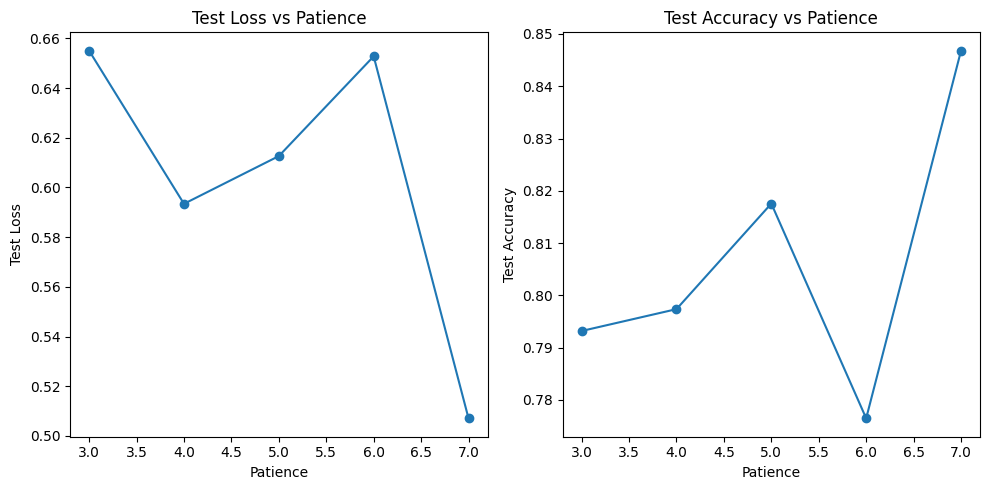

In [ ]:
from tabulate import tabulate
import matplotlib.pyplot as plt

# Array of different values of patience
patience_array = [3, 4, 5, 6, 7]
result3 = []

for patience in patience_array:
    print(f"\nTraining model with patience={patience}")
    temp = []
    model = build_dnn(input_shape, learning_rate=LEARNING_RATE, num_classes=8)
    history = train(model, EPOCHS, BATCH_SIZE, patience, X_train, y_train, X_validation, y_validation)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test loss with patience={patience}: {test_loss}, Test accuracy: {test_acc}")
    temp.extend([patience, test_loss, test_acc])
    result3.append(temp)

# Create header
head3 = ["Patience", "Test Loss", "Test Accuracy"]

# Display table
print(tabulate(result3, headers=head3, tablefmt="grid"))

# Plotting test loss and accuracy for each value of patience
patience_values = [row[0] for row in result3]
test_losses = [row[1] for row in result3]
test_accuracies = [row[2] for row in result3]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(patience_values, test_losses, marker='o')
plt.title('Test Loss vs Patience')
plt.xlabel('Patience')
plt.ylabel('Test Loss')

plt.subplot(1, 2, 2)
plt.plot(patience_values, test_accuracies, marker='o')
plt.title('Test Accuracy vs Patience')
plt.xlabel('Patience')
plt.ylabel('Test Accuracy')

plt.tight_layout()
plt.show()
